In [1]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp

from jax import config
config.update("jax_enable_x64", True)

In [2]:
from typing import Any, Dict, List
from functools import partial
import numpy as np

from transformer_payne.spectrum_emulator import SpectrumEmulator

import jax
import jax.numpy as jnp
from jax.typing import ArrayLike

    
h = 6.62607015e-27  # Planck's constant [erg*s]
c = 2.99792458e10   # Speed of light [cm/s]
k = 1.380649e-16    # Boltzmann constant [erg/K]


class TwoLayersWithLine:
    @property
    def parameter_names(self) -> List[str]:
        """Get labels of spectrum model parameters

        Returns:
            List[str]:
        """
        return ["T_bg", "T_fg", "line_width", "rho0"]
    
    @property
    def min_parameters(self) -> ArrayLike:
        """Minimum values supported by the spectrum model

        Returns:
            ArrayLike:
        """
        return jnp.array([0., 0., 0., 0.], dtype=jnp.float32)
    
    @property
    def max_parameters(self) -> ArrayLike:
        """Maximum values supported by the spectrum model

        Returns:
            ArrayLike:
        """
        return jnp.array([jnp.inf, jnp.inf, jnp.inf, jnp.inf], dtype=jnp.float32)
    
    @property
    def stellar_parameter_names(self) -> ArrayLike:
        return self.parameter_names()
    
    @property
    def min_stellar_parameters(self) -> ArrayLike:
        return self.min_stellar_parameters()
    
    @property
    def max_stellar_parameters(self) -> ArrayLike:
        return self.max_stellar_parameters()
    
    @staticmethod
    def is_in_bounds(parameters: ArrayLike) -> bool:
        """Check if parameters are within the bounds of the spectrum model

        Args:
            parameters (ArrayLike):

        Returns:
            bool:
        """
        return jnp.all(parameters >= 0.)
    
    @property
    def solar_parameters(self) -> ArrayLike:
        """Solar parameters for the spectrum model

        Returns:
            ArrayLike:
        """
        return jnp.array([5777., 5000., 0.1, 3e-11])
    
    def to_parameters(self, parameter_values: Dict[str, Any] = None) -> ArrayLike:
        """Convert passed values to the accepted parameters format

        Args:
            parameter_values (Dict[str, Any], optional): parameter values in the format of {'parameter_name': value}. Unset parameters will be set to solar values.

        Raises:
            ValueError: when the parameters are out of accepted bounds

        Returns:
            ArrayLike:
        """
        if not parameter_values:
            return self.solar_parameters
        
        T_bg = parameter_values.get('T_bg', self.solar_parameters[0])
        T_fg = parameter_values.get('T_fg', self.solar_parameters[1])
        line_width = parameter_values.get('line_width', self.solar_parameters[2])
        rho0 = parameter_values.get('rho0', self.solar_parameters[3])
        
        return jnp.array([T_bg, T_fg, line_width, rho0])
    
    @staticmethod
    def flux(log_wavelengths: ArrayLike, spectral_parameters: ArrayLike, mus_number: int = 20) -> ArrayLike:
        """Compute the blackbody flux.

        Args:
            log_wavelengths (ArrayLike): Array of logarithmic wavelengths (log10 of wavelength in Angstroms).
            parameters (ArrayLike): Array of parameters. In this case, only one element is used which represents the temperature in Kelvin.

        Returns:
            ArrayLike: Array of blackbody monochromatic fluxes in erg/s/cm3
        """
        roots, weights = np.polynomial.legendre.leggauss(mus_number)
        roots = (roots + 1) / 2
        weights /= 2
        return _flux(tuple(roots), tuple(weights), _intensity, log_wavelengths, spectral_parameters)

    @staticmethod
    def intensity(log_wavelengths: ArrayLike, mu: float, spectral_parameters: ArrayLike) -> ArrayLike:
        """Calculate the intensity for given wavelengths and mus

        Args:
            log_wavelengths (ArrayLike): [log(angstrom)]
            mu (float): cosine of the angle between the star's radius and the line of sight. As the blackbody radiation field is isotropic, this parameter is not used.
            spectral_parameters (ArrayLike): an array of predefined stellar parameters. In this case, only one element is used which represents the temperature in Kelvin.

        Returns:
            ArrayLike: monochromatic intensities corresponding to passed wavelengths [erg/s/cm3/steradian]
        """

        return _intensity(log_wavelengths, mu, spectral_parameters)

    @staticmethod
    def intensity_linear_limb_darkening(log_wavelengths: ArrayLike, mu: float, spectral_parameters: ArrayLike, limb_darkening_coeff: float = 0.6) -> ArrayLike:
        """Calculate the intensity for given wavelengths and mus

        Args:
            log_wavelengths (ArrayLike): [log(angstrom)]
            mu (float): cosine of the angle between the star's radius and the line of sight. As the blackbody radiation field is isotropic, this parameter is not used.
            spectral_parameters (ArrayLike): an array of predefined stellar parameters. In this case, only one element is used which represents the temperature in Kelvin.

        Returns:
            ArrayLike: monochromatic intensities corresponding to passed wavelengths [erg/s/cm3/steradian]
        """

        return _intensity(log_wavelengths, 1.0, spectral_parameters) * (1 - limb_darkening_coeff*(1 - mu))

    
    @staticmethod
    def flux_linear_limb_darkening(log_wavelengths: ArrayLike, spectral_parameters: ArrayLike, mus_number: int = 20, limb_darkening_coeff: float = 0.6) -> ArrayLike:
        """Compute the blackbody flux.

        Args:
            log_wavelengths (ArrayLike): Array of logarithmic wavelengths (log10 of wavelength in Angstroms).
            parameters (ArrayLike): Array of parameters. In this case, only one element is used which represents the temperature in Kelvin.

        Returns:
            ArrayLike: Array of blackbody monochromatic fluxes in erg/s/cm3
        """
        roots, weights = np.polynomial.legendre.leggauss(mus_number)
        roots = (roots + 1) / 2
        weights /= 2
        _intensity_lld = jax.jit(lambda log_wavelengths, mu, spectral_parameters: _intensity(log_wavelengths, 1.0, spectral_parameters) * (1 - limb_darkening_coeff*(1 - mu)))
        return _flux(tuple(roots), tuple(weights), _intensity_lld , log_wavelengths, spectral_parameters)
    

def B_w(wave, T):
    return 2*h*c**2/wave**5/(jnp.exp(h*c/(wave*k*T))-1)

@jax.jit
def _intensity(log_wavelengths, mu, spectral_parameters):
    # Convert log wavelength from angstroms to cm
    # wave_cm = 10 ** (log_wavelengths - 8)  # 1 Angstrom = 1e-8 cm
    # Convert log wavelength from angstroms to frequency in Hz
    wave_cm = 10 ** (log_wavelengths - 8)

    # Get parameters for the intenisty function
    dz = 5e8 # cm
    wave_0 = 5500.0 * 1e-8 # cm
    eps = 1e-10
    # ---
    T_bg = spectral_parameters[0] # K - balckground radiation temperature
    T_fg = spectral_parameters[1] # K - foreground matter temperature
    line_width = spectral_parameters[2] * 1e-8 # cm - line width in angstroms
    rho0 = spectral_parameters[3] # g/cm3 - foreground matter density

    # Compute opacity of a layer: line
    
    kappa_cont = 1e-1 * 1e-7 / (jnp.pi*line_width)   # constant continuum opacity [cm2/g] = 1e-1 * maximum line opacity
    kappa_line = 1e-7 * line_width / jnp.pi / ((wave_cm - wave_0)**2 + line_width**2)
    kappa = kappa_line + kappa_cont

    exptau_cont = jnp.exp(- kappa_cont * rho0 * dz / mu )
    exptau = jnp.exp(- kappa * rho0 * dz / mu )

    intensity_cont = B_w(wave_cm, T_bg) * exptau_cont + (1 - exptau_cont) * B_w(wave_cm, T_fg)
    intensity = B_w(wave_cm, T_bg) * exptau + (1 - exptau) * B_w(wave_cm, T_fg)

    # Stack into one array
    y = jnp.stack([intensity, intensity_cont], axis=1)
    y = jnp.where(jnp.isnan(y), 0.0, y)
    return y

@partial(jax.jit, static_argnums=(0, 1, 2))
def _flux(roots: ArrayLike, weights: ArrayLike, intensity_method: callable,
          log_wavelengths: ArrayLike, spectral_parameters: ArrayLike):
    roots, weights = jnp.array(roots), jnp.array(weights)
    return 2*jnp.pi*jnp.sum(
        jax.vmap(intensity_method, in_axes=(None, 0, None))(log_wavelengths, roots, spectral_parameters)*
        roots[:, jnp.newaxis, jnp.newaxis]*weights[:, jnp.newaxis, jnp.newaxis],
        axis=0
    )

In [3]:
vws = jnp.linspace(1000., 30000., 1000000)

In [4]:
tlm = TwoLayersWithLine()

We have a model of a stellar atmosphere. It consists of a black body radiator in the background and a layer of gas on top. This layer of gas exhibits some continuum absorption and one absorption feature due to additional opacity concentrated around 5500 $\AA$ (~a spectral line). The model includes an exact version where the flux and intensity are precisely calculated, as well as a version that approximates the angular dependence using the linear limb darkening law.

See two sections below to understand the overall picture.

## Two Layers with Single Line: Intensity for a chosen angle, Exact integration

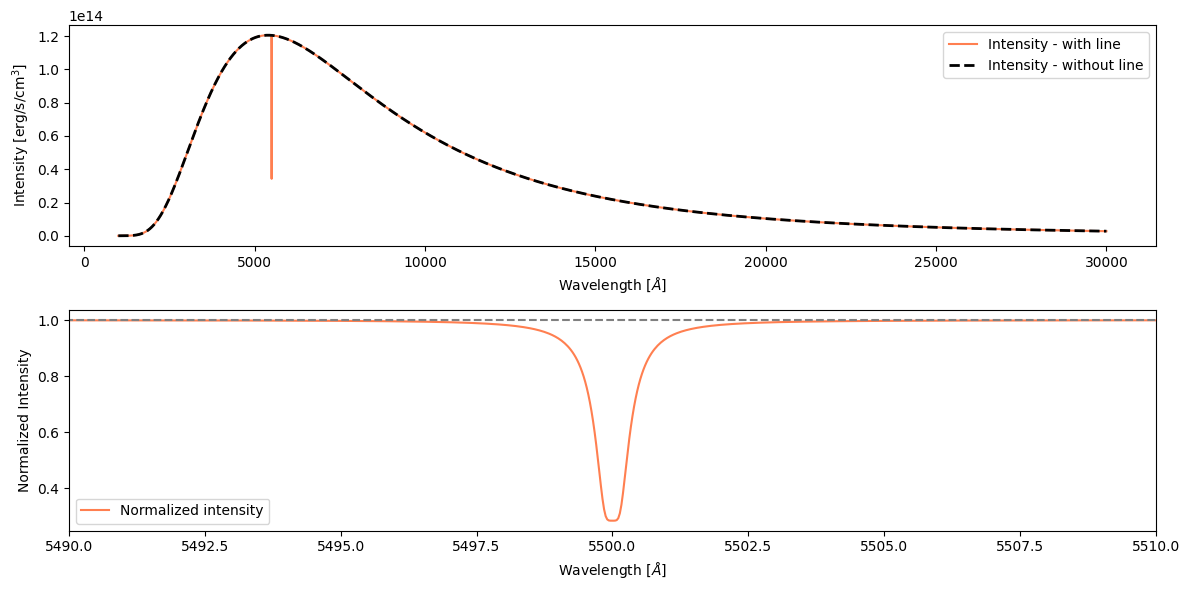

In [13]:
mu = jnp.array([0.5])
p = jnp.array([5777., 4000., 0.1, 3e-10]) # [T_bg, T_fg, gamma, rho0] # K, K, Angstrom, g cm-3
intensity = tlm.intensity(jnp.log10(vws), mu, p)

# ---

fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize=(12, 6))
ax1.plot(vws, intensity[:,0], label='Intensity - with line', color='coral')
ax1.plot(vws, intensity[:,1], label='Intensity - without line', color='black', linestyle='--', linewidth=2)
ax1.set_xlabel(r'Wavelength [$\AA$]')
ax1.set_ylabel('Intensity [erg/s/cm$^3$]')
ax1.legend()

# Zoom into normalized intensity
ax2.plot(vws, intensity[:,0]/intensity[:,1], label='Normalized intensity', color='coral')
ax2.hlines(1, 5000, 6000, colors='r', linestyles='dashed', color='gray')
ax2.set_xlabel(r'Wavelength [$\AA$]')
ax2.set_ylabel('Normalized Intensity')
ax2.legend()
ax2.set_xlim(5490, 5510)

fig.tight_layout()
plt.show()

## Two Layers with Single Line: Intensity for a set of angles + limb darkening in line center and in the continuum



In [14]:
mus = jnp.array([1.0, 0.3, 0.1, 0.03, 0.01])
p = jnp.array([5777., 4000., 0.1, 3e-11]) # [T_bg, T_fg, gamma, rho0] # K, K, Angstrom, g cm-3
limb_darkening_coeff = 0.6
intensities = jnp.array([tlm.intensity(jnp.log10(vws), mu, p) for mu in mus])
intensities_lld = jnp.array([tlm.intensity_linear_limb_darkening(jnp.log10(vws), mu, p, limb_darkening_coeff) for mu in mus])

<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
/jobfs/140834122.gadi-pbs/ipykernel_57877/1173261497.py:9: SyntaxWarning: invalid escape sequence '\m'
  ax1[0].plot(vws, intensities[i, :, 0], label=f'$\mu$={mu:.3f}', color=colors[i])
/jobfs/140834122.gadi-pbs/ipykernel_57877/1173261497.py:10: SyntaxWarning: invalid escape sequence '\m'
  ax2[0].plot(vws, intensities[i, :, 0] / intensities[i][:, 1], label=f'$\mu$={mu:.3f}', color=colors[i])
/jobfs/140834122.gadi-pbs/ipykernel_57877/1173261497.py:24: SyntaxWarning: invalid escape sequence '\m'
  ax1[1].plot(vws, intensities_lld[i, :, 0], label=f'$\mu$={mu:.3f}', color=colors[i])
/jobfs/

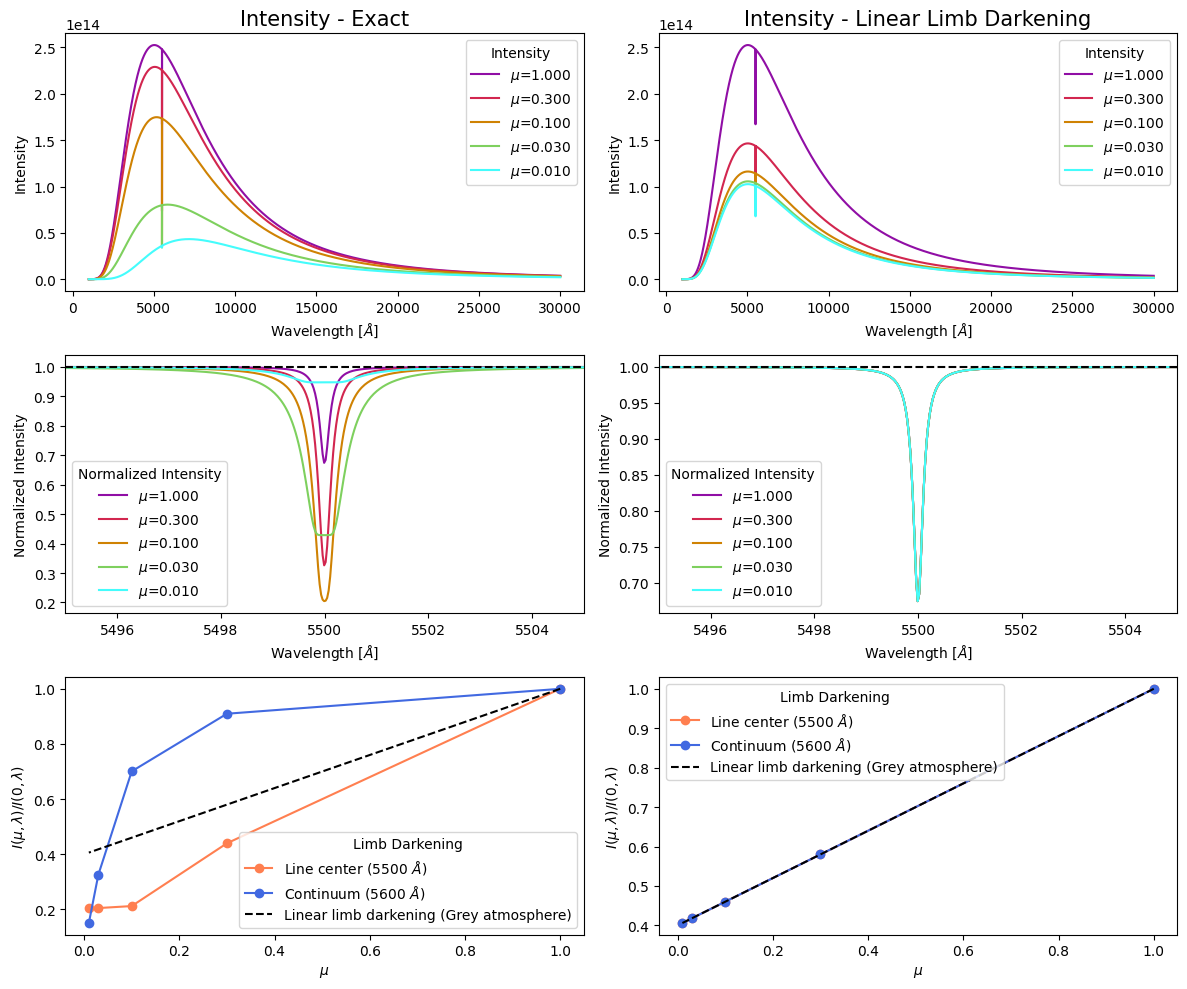

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

# Plotting limb-darkened intensities in the second column
import cmasher as cmr
colors = cmr.take_cmap_colors('cmr.tropical', len(mus), cmap_range=(0, 1))

# Plotting original intensities in the first column
for i, mu in enumerate(mus):
    ax1[0].plot(vws, intensities[i, :, 0], label=f'$\mu$={mu:.3f}', color=colors[i])
    ax2[0].plot(vws, intensities[i, :, 0] / intensities[i][:, 1], label=f'$\mu$={mu:.3f}', color=colors[i])

ax1[0].set_xlabel(r'Wavelength [$\AA$]')
ax1[0].set_ylabel('Intensity')
ax1[0].legend(title="Intensity")

ax2[0].hlines(1, 5000, 6000, colors='k', linestyles='dashed')
ax2[0].set_xlabel(r'Wavelength [$\AA$]')
ax2[0].set_ylabel('Normalized Intensity')
ax2[0].legend(title='Normalized Intensity')
ax2[0].set_xlim(5495, 5505)


for i, mu in enumerate(mus):
    ax1[1].plot(vws, intensities_lld[i, :, 0], label=f'$\mu$={mu:.3f}', color=colors[i])
    ax2[1].plot(vws, intensities_lld[i, :, 0] / intensities_lld[i][:, 1], label=f'$\mu$={mu:.3f}', color=colors[i])

ax1[1].set_xlabel(r'Wavelength [$\AA$]')
ax1[1].set_ylabel('Intensity')
ax1[1].legend(title="Intensity")

ax2[1].hlines(1, 5000, 6000, colors='k', linestyles='dashed')
ax2[1].set_xlabel(r'Wavelength [$\AA$]')
ax2[1].set_ylabel('Normalized Intensity')
ax2[1].legend(title='Normalized Intensity')
ax2[1].set_xlim(5495, 5505)

# Plot intensity for different mu for a chosen wavelengths [5500, 5600] in the third row
idx_w0 = jnp.argmin(jnp.abs(vws - 5500))
idx_w1 = jnp.argmin(jnp.abs(vws - 5600))

ax3[0].plot(mus, intensities[:, idx_w0, 0] / intensities[0, idx_w0, 0], "o-", color='coral', label=r"Line center (5500 $\AA$)")
ax3[0].plot(mus, intensities[:, idx_w1, 0] / intensities[0, idx_w1, 0], "o-", color='royalblue', label=r"Continuum (5600 $\AA$)")
ax3[0].plot(mus, 1 - 0.6 * (1 - mus), "--", color='black', label="Linear limb darkening (Grey atmosphere)")
ax3[0].set_xlabel(r"$\mu$")
ax3[0].set_ylabel(r"$I(\mu, \lambda) / I(0, \lambda)$")
ax3[0].legend(title="Limb Darkening")

ax3[1].plot(mus, intensities_lld[:, idx_w0, 0] / intensities_lld[0, idx_w0, 0], "o-", color='coral', label=r"Line center (5500 $\AA$)")
ax3[1].plot(mus, intensities_lld[:, idx_w1, 0] / intensities_lld[0, idx_w1, 0], "o-", color='royalblue', label=r"Continuum (5600 $\AA$)")
ax3[1].plot(mus, 1 - 0.6 * (1 - mus), "--", color='black', label="Linear limb darkening (Grey atmosphere)")
ax3[1].set_xlabel(r"$\mu$")
ax3[1].set_ylabel(r"$I(\mu, \lambda) / I(0, \lambda)$")
ax3[1].legend(title="Limb Darkening")

ax1[0].set_title("Intensity - Exact",fontsize=15)
ax1[1].set_title("Intensity - Linear Limb Darkening", fontsize=15)

plt.tight_layout()
plt.show()

## Rotating star in various approximations (exact / linear limb darkening)

In [19]:
from spice.models import IcosphereModel
from spice.models.mesh_transform import add_rotation, evaluate_rotation
import astropy.units as u
from spice.spectrum import simulate_observed_flux

min_number_of_triangles = 1000
chunk_size = 1
vws = jnp.geomspace(5450., 5550., 10000)

p =  jnp.array([5777., 4000., 0.1, 3e-11]) # [T_bg, T_fg, gamma, rho0] # K, K, Angstrom, g cm-3

m = IcosphereModel.construct(min_number_of_triangles, 1., 1., p, ['T_bg', 'T_fg', 'line_width', 'rho0']) # took ~4min23sec for 1500 (macbook pro 2019), 3.8sec for 1000

/home/100/mj8805/scr/mj8805/miniconda3/envs/astro/lib/python3.12/site-packages/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


### Compare flux to spectrum integrated from star without rotation

They should be the same - let's confirm it by direct evaluation.

In [20]:
flux = tlm.flux(jnp.log10(vws), p)
spec_no_rot = simulate_observed_flux(tlm.intensity, m, jnp.log10(vws), chunk_size=chunk_size)

flux_lld = tlm.flux_linear_limb_darkening(jnp.log10(vws), p)
spec_no_rot_lld = simulate_observed_flux(tlm.intensity_linear_limb_darkening, m, jnp.log10(vws), chunk_size=chunk_size)

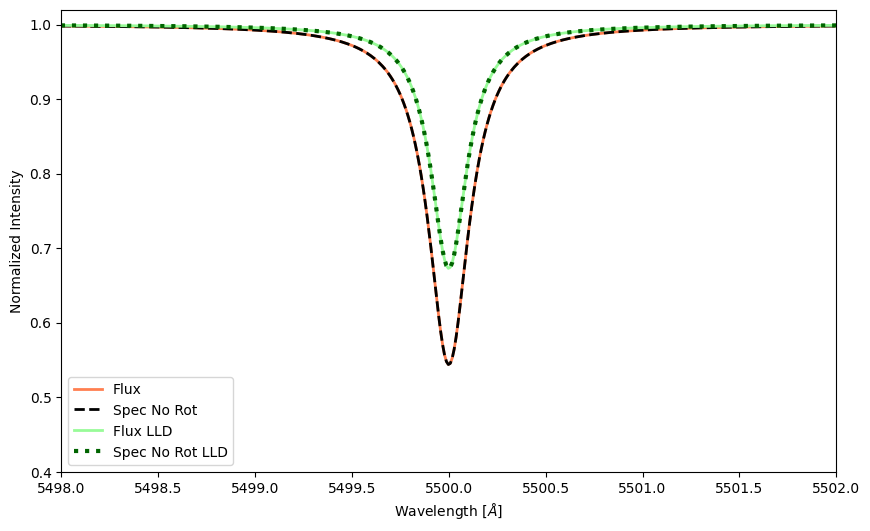

In [28]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(vws, flux[:, 0] / flux[:, 1], label='Flux', color='coral', linestyle='-', linewidth=2)
ax.plot(vws, spec_no_rot[:, 0] / spec_no_rot[:, 1], label='Spec No Rot', color='black', linestyle='--', linewidth=2)

ax.plot(vws, flux_lld[:, 0] / flux_lld[:, 1], label='Flux LLD', color='palegreen', linestyle='-', linewidth=2)
ax.plot(vws, spec_no_rot_lld[:, 0] / spec_no_rot_lld[:, 1], label='Spec No Rot LLD', color='darkgreen', linestyle='dotted', linewidth=3)

ax.set_xlim(5498, 5502)
ax.set_ylim(0.40, 1.02)
ax.set_xlabel(r'Wavelength [$\AA$]')
ax.set_ylabel('Normalized Intensity')
ax.legend()
plt.show()

### Rotation with exact / linear limb darkening

Here we expect that the convolution with broadening kernel derived analytically will be exact for linear limb darkening emulator while not appropriate for exact model. Let's confirm this with emulation. 

Note: We keep number of triangles to be small to show the effects of imperfect numerical integration.

In [31]:
from spice.spectrum import simulate_observed_flux

spectra_rot = [] # rotationally broadened specta with exact intensities
vsinis = [0, 3, 10, 30, 100, 300]
for vsini in vsinis:

    mt = add_rotation(m, vsini, jnp.array([0., 0., 1.]))
    mt = evaluate_rotation(mt, 0.0)
    %time spec_vsini = simulate_observed_flux(tlm.intensity, mt, jnp.log10(vws), chunk_size=chunk_size).block_until_ready()

    spectra_rot.append(spec_vsini)

spectra_rot_lld = [] # rotationally broadened specta with linear limb darkening
for vsini in vsinis:

    mt = add_rotation(m, vsini, jnp.array([0., 0., 1.]))
    mt = evaluate_rotation(mt, 0.0)
    %time spec_vsini = simulate_observed_flux(tlm.intensity_linear_limb_darkening, mt, jnp.log10(vws), chunk_size=chunk_size).block_until_ready()

    spectra_rot_lld.append(spec_vsini)

flux_exact = tlm.flux(jnp.log10(vws), p)
flux_exact_lld = tlm.flux_linear_limb_darkening(jnp.log10(vws), p)
    

CPU times: user 13.3 s, sys: 1.92 s, total: 15.2 s
Wall time: 15.2 s
CPU times: user 12.6 s, sys: 1.81 s, total: 14.4 s
Wall time: 14.4 s
CPU times: user 12.6 s, sys: 1.82 s, total: 14.4 s
Wall time: 14.4 s
CPU times: user 12.5 s, sys: 1.83 s, total: 14.3 s
Wall time: 14.3 s
CPU times: user 12.5 s, sys: 1.8 s, total: 14.3 s
Wall time: 14.3 s
CPU times: user 12.5 s, sys: 1.74 s, total: 14.2 s
Wall time: 14.2 s
CPU times: user 12.7 s, sys: 1.71 s, total: 14.4 s
Wall time: 14.4 s
CPU times: user 12.2 s, sys: 1.62 s, total: 13.8 s
Wall time: 13.8 s
CPU times: user 12.3 s, sys: 1.53 s, total: 13.8 s
Wall time: 13.8 s
CPU times: user 12.2 s, sys: 1.62 s, total: 13.8 s
Wall time: 13.8 s
CPU times: user 12.2 s, sys: 1.57 s, total: 13.8 s
Wall time: 13.8 s
CPU times: user 12.2 s, sys: 1.59 s, total: 13.8 s
Wall time: 13.8 s


In [32]:
import matplotlib.pyplot as plt
from utils import add_vsini_broadening

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))  # Create 6 subplots

# Define line styles
line_styles = ['-', '--']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
alpha = 0.5
limits = [1,1,2,2,6,6]

normalized_flux_exact = flux_exact[:, 0] / flux_exact[:, 1]
normalized_flux_exact_lld = flux_exact_lld[:, 0] / flux_exact_lld[:, 1]

for i, vsini in enumerate(vsinis):
    ax = axes[i // 2, i % 2]  # Get the appropriate subplot
    color = colors[i % len(colors)]

    # Plot linear limb darkening
    sp_lld = spectra_rot_lld[i]
    ax.plot(vws, sp_lld[:, 0] / sp_lld[:, 1], label=f'Integration LLD', color=colors[0], linestyle=line_styles[0], alpha=alpha)
    
    # Plot exact model
    sp_exact = spectra_rot[i]
    ax.plot(vws, sp_exact[:, 0] / sp_exact[:, 1], label=f'Integration Exact', color=colors[1], linestyle=line_styles[0], alpha=alpha)
    
    # Plot spectra convolved with analytical rotational kernel with linear limb darkening:
    if vsini > 0.0:
        flux_conv_lld_vsini = add_vsini_broadening(np.log10(vws), normalized_flux_exact_lld, vsini=vsini, limb_darkening_coeff=0.6)
    else:
        flux_conv_lld_vsini = normalized_flux_exact_lld
    ax.plot(vws, flux_conv_lld_vsini, label=f'Convolution LLD', color=colors[2], linestyle=line_styles[1], alpha=alpha)

    # Plot flux convolved with analytical rotational kernel with linear limb darkening:
    if vsini > 0.0:
        flux_conv_lld_vsini = add_vsini_broadening(np.log10(vws), normalized_flux_exact, vsini=vsini, limb_darkening_coeff=0.6)
    else:
        flux_conv_lld_vsini = normalized_flux_exact
    ax.plot(vws, flux_conv_lld_vsini, label=f'Convolution Exact', color=colors[3], linestyle=line_styles[1], alpha=alpha)

    ax.hlines(1, 5000, 6000, colors='k', linestyles='dashed')
    ax.set_xlabel('Wavelength (Angstrom)')
    ax.set_ylabel('Normalized Intensity')
    ax.legend(title=f"VSINI = {vsini:.1f} km/s")
    ax.set_xlim(5500-limits[i], 5500+limits[i])

plt.tight_layout()


ModuleNotFoundError: No module named 'utils'